

```
#Pooja Meshram
NLP Project 3

```



Fine-Tune BERT model on amazon alexa file


In [1]:
# Install Transformers Library
!pip install -q transformers

In [16]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset
import tensorflow_datasets as tfds
from transformers import TFBertForSequenceClassification
import tensorflow as tf
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TFDistilBertModel, DistilBertConfig


In [5]:
# Step 2: Load and Convert Dataset to TensorFlow Dataset
data_path = 'amazon_alexa.tsv'
data = pd.read_csv(data_path, sep='	')

In [6]:
# Handle null values in `verified_reviews`
data = data.dropna(subset=['verified_reviews'])

In [7]:
# Convert to TensorFlow Dataset
texts = data['verified_reviews'].tolist()
labels = data['feedback'].tolist()

In [8]:
def generate_tf_dataset(texts, labels):
    for text, label in zip(texts, labels):
        yield text, label


In [9]:
# Create TensorFlow Dataset
tf_dataset = tf.data.Dataset.from_generator(
    generate_tf_dataset,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    ),
    args=(texts, labels)
)


In [10]:
# Split into Train and Test Sets
dataset_size = len(texts)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

tf_dataset = tf_dataset.shuffle(buffer_size=dataset_size, seed=42)
train_dataset = tf_dataset.take(train_size)
test_dataset = tf_dataset.skip(train_size)


In [11]:
# Step 3: Tokenization
# Define tokenizer
# DistilBERT Tokenizer and Model Initialization
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [12]:
# Set constants
# Can be up to 512 for BERT
max_length = 512
batch_size = 6

In [13]:
# Recommended learning rate for Adam optimizer: 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

In [14]:
# Custom training with DistilBERT
# Configure DistilBERT's initialization
DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.2
config = DistilBertConfig(dropout=DISTILBERT_DROPOUT,
                          attention_dropout=DISTILBERT_ATT_DROPOUT,
                          output_hidden_states=True)

In [15]:
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states
# and without any specific head on top.
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [16]:
# Make DistilBERT layers untrainable
for layer in distilBERT.layers:
    layer.trainable = False

In [17]:
# Model initialization
# TFBertForSequenceClassification adds the classification layer
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)


In [19]:
# We do not have one-hot vectors, so using sparse categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

In [20]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [33]:
# Function to convert examples to features
def convert_example_to_feature(review):
    return tokenizer.encode_plus(review,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_masks,
    }, label

def encode_examples(ds, limit=-1):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = [] # positions of the words in the vocabulary
    token_type_ids_list = [] # sentence segmentation id
    attention_mask_list = [] # mask/nomask labels
    label_list = []
    if (limit > 0):
        ds = ds.take(limit)
    for review, label in tfds.as_numpy(ds):
        bert_input = convert_example_to_feature(review.decode()) # converts input examples to input features
        # add the outputs to the lists
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
    # converts lists to tensors
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)


In [37]:
# Encode datasets
# Train dataset
ds_train_encoded = encode_examples(train_dataset).shuffle(10000).batch(batch_size)
# Test dataset
ds_test_encoded = encode_examples(test_dataset).batch(batch_size)

# Train the model
number_of_epochs = 1
bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded)

# Test Prediction
test_sentence = data['verified_reviews'].iloc[10]

predict_input = tokenizer.encode(test_sentence, truncation=True, padding=True, return_tensors="tf")

inputs = tokenizer(data['verified_reviews'].iloc[5], return_tensors="pt")
inputs.pop('token_type_ids', None)

with torch.inference_mode():
    logits = model(**inputs).logits
predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

tf_output = model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Negative', 'Positive']  # (0:negative, 1:positive)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 15/410 [>.............................] - ETA: 5:04:02 - loss: 0.3706 - accuracy: 0.9111

KeyboardInterrupt: 

In [38]:
# Step 4: Load Pre-trained BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# Step 5: Define Training Setup
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [20]:
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [52]:
import pandas as pd

# Load the Amazon Alexa reviews dataset
file_path = 'amazon_alexa.tsv'  # Update with the correct file path
data = pd.read_csv(file_path, sep='\t')

# Drop missing values
data = data.dropna(subset=['verified_reviews'])

# Extract texts and labels
texts = data['verified_reviews'].tolist()
labels = data['feedback'].tolist()

from transformers import BertTokenizer

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [53]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Tokenize and encode the datasets
def encode_dataset(texts, labels):
    encodings = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    dataset = [
        {'input_ids': encodings['input_ids'][i],
         'attention_mask': encodings['attention_mask'][i],
         'labels': torch.tensor(labels[i], dtype=torch.long)}
        for i in range(len(labels))
    ]
    return dataset

train_dataset = encode_dataset(train_texts, train_labels)
test_dataset = encode_dataset(test_texts, test_labels)

# Create DataLoaders
batch_size = 16
ds_train_encoded = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
ds_test_encoded = DataLoader(test_dataset, batch_size=batch_size)


In [54]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Tokenize and encode the datasets
def encode_dataset(texts, labels):
    encodings = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    dataset = [
        {'input_ids': encodings['input_ids'][i],
         'attention_mask': encodings['attention_mask'][i],
         'labels': torch.tensor(labels[i], dtype=torch.long)}
        for i in range(len(labels))
    ]
    return dataset

train_dataset = encode_dataset(train_texts, train_labels)
test_dataset = encode_dataset(test_texts, test_labels)

# Create DataLoaders
batch_size = 16
ds_train_encoded = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
ds_test_encoded = DataLoader(test_dataset, batch_size=batch_size)


In [55]:
# Step 5: Define and Encode Training and Test Datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Assuming 'data' is a Pandas DataFrame containing 'verified_reviews' and 'feedback'
texts = data['verified_reviews'].tolist()
labels = data['feedback'].tolist()

# Split into train and test datasets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Tokenize and encode the datasets
def encode_dataset(texts, labels):
    encodings = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    dataset = [
        {'input_ids': encodings['input_ids'][i],
         'attention_mask': encodings['attention_mask'][i],
         'labels': torch.tensor(labels[i], dtype=torch.long)}
        for i in range(len(labels))
    ]
    return dataset

train_dataset = encode_dataset(train_texts, train_labels)
test_dataset = encode_dataset(test_texts, test_labels)

# Create DataLoaders
batch_size = 16
ds_train_encoded = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
ds_test_encoded = DataLoader(test_dataset, batch_size=batch_size)

In [3]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

# Initialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set optimizer, loss, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 6: Training Loop

# Ensure ds_train_encoded and ds_test_encoded are properly initialized
if 'ds_train_encoded' not in locals() or 'ds_test_encoded' not in locals():
    raise ValueError("Datasets ds_train_encoded and ds_test_encoded must be initialized before the training loop.")

for epoch in range(3):  # 3 epochs for demonstration
    model.train()
    for batch in ds_train_encoded:
        optimizer.zero_grad()
        # Unpack the batch if it is a dictionary
        if isinstance(batch, dict):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
        else:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    for batch in ds_test_encoded:
        with torch.no_grad():
            if isinstance(batch, dict):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
            else:
                input_ids, attention_mask, labels = batch
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

    print(f"Epoch {epoch + 1}: Validation Loss = {val_loss / len(ds_test_encoded):.4f}")


In [9]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

# Initialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set optimizer, loss, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Step 7: Save the Model
model.save_pretrained('./Fine_tuned_bert_amazon3')
tokenizer.save_pretrained('./Fine_tuned_bert_amazon3')

('./Fine_tuned_bert_amazon3/tokenizer_config.json',
 './Fine_tuned_bert_amazon3/special_tokens_map.json',
 './Fine_tuned_bert_amazon3/vocab.txt',
 './Fine_tuned_bert_amazon3/added_tokens.json')

Lets try few methods of 2nd colab file given by professor.

In [14]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [29]:
df = pd.read_csv("amazon_alexa.tsv", sep='\t')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [30]:
df.shape

(3150, 5)

In [32]:
df['feedback'].value_counts(normalize=True)


,proportion
feedback,
1,0.918413
0,0.081587


In [34]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['verified_reviews'], df['feedback'],
                                                                    random_state=2023,
                                                                    test_size=0.3,
                                                                    stratify=df['feedback'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2023,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [35]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# AutoModel is a generic model class that can be used to instantiate any of the base model class in the
# Transformer library

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [36]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


<Axes: >

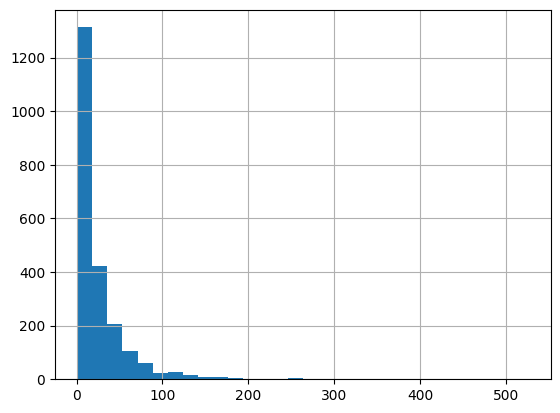

In [38]:
# get length of all the messages in the train set
seq_len = [len(str(i).split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [45]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.astype(str).tolist(), # Convert each element of the Series to a string
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [47]:
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.astype(str).tolist(),  # Convert elements of val_text to strings before tokenization
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [49]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.astype(str).tolist(),  # Convert elements to strings before tokenization
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [50]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [51]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# create the DataLoader for our training set
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# # create the DataLoader for our training set
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [52]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [2]:
import torch.nn as nn #Import nn module

# Create the BertClassifier class
class BERT_Arch(nn.Module): #Define BERT_Arch once
    """Bert model for Classification Tasks
    """
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [9]:
# Create the BertClassifier class
class BERT_Arch(nn.Module):
    """Bert model for Classification Tasks
    """
    #def __init__(self,freeze_bert=False):
    def __init__(self, bert):

      super(BERT_Arch, self).__init__()
      # Instantiate the BERT model
      #self.bert = AutoModel.from_pretrained('bert-base-uncased')
      self.bert = bert

      # Custom layer
      self.dropout = nn.Dropout(0.1) # dropout layer
      self.relu =  nn.ReLU() # relu activation function
      self.fc1 = nn.Linear(768,512) # dense layer 1
      self.fc2 = nn.Linear(512,2)  # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1) #softmax activation function

      ## Freeze the BERT model
       # if freeze_bert:
       #     for param in self.bert.parameters():
       #         param.requires_grad = Flase

    #define the forward pass
    def forward(self, sent_id, mask):
        ""
        Feed input to BERT and the classifier to compute logits.
        @param    sent_id (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """"""
      #Feed input to BERT
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      # the output from BERT's [CLS] token is passed through custom layers
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc2(x)
      # apply softmax activation - logits are outputted !
      x = self.softmax(x)

      return x

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 37)

In [11]:
# Create the BertClassifier class
class BERT_Arch(nn.Module):
    """Bert model for Classification Tasks
    """
    #def __init__(self,freeze_bert=False):
    def __init__(self, bert):

        super(BERT_Arch, self).__init__()
        # Instantiate the BERT model
        #self.bert = AutoModel.from_pretrained('bert-base-uncased')
        self.bert = bert

        # Custom layer
        self.dropout = nn.Dropout(0.1) # dropout layer
        self.relu =  nn.ReLU() # relu activation function
        self.fc1 = nn.Linear(768,512) # dense layer 1
        self.fc2 = nn.Linear(512,2)  # dense layer 2 (Output layer)
        self.softmax = nn.LogSoftmax(dim=1) #softmax activation function

        ## Freeze the BERT model
        # if freeze_bert:
        #     for param in self.bert.parameters():
        #         param.requires_grad = Flase

    #define the forward pass
# Create the BertClassifier class
class BERT_Arch(nn.Module):
    """Bert model for Classification Tasks
    """
    #def __init__(self,freeze_bert=False):
    def __init__(self, bert):

        super(BERT_Arch, self).__init__()
        # Instantiate the BERT model
        #self.bert = AutoModel.from_pretrained('bert-base-uncased')
        self.bert = bert

        # Custom layer
        self.dropout = nn.Dropout(0.1) # dropout layer
        self.relu =  nn.ReLU() # relu activation function
        self.fc1 = nn.Linear(768,512) # dense layer 1
        self.fc2 = nn.Linear(512,2)  # dense layer 2 (Output layer)
        self.softmax = nn.LogSoftmax(dim=1) #softmax activation function

        ## Freeze the BERT model
        # if freeze_bert:
        #     for param in self.bert.parameters():
        #         param.requires_grad = Flase

    #define the forward pass
    def forward(self, sent_id, mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    sent_id (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        #Feed input to BERT
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False) # Corrected indentation
        # the output from BERT's [CLS] token is passed through custom layers
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.fc2(x)
        # apply softmax activation - logits are outputted !
        x = self.softmax(x)
# Create the BertClassifier class
class BERT_Arch(nn.Module):
    """Bert model for Classification Tasks
    """
    #def __init__(self,freeze_bert=False):
    def __init__(self, bert):

        super(BERT_Arch, self).__init__()
        # Instantiate the BERT model
        #self.bert = AutoModel.from_pretrained('bert-base-uncased')
        self.bert = bert

        # Custom layer
        self.dropout = nn.Dropout(0.1) # dropout layer
        self.relu =  nn.ReLU() # relu activation function
        self.fc1 = nn.Linear(768,512) # dense layer 1
        self.fc2 = nn.Linear(512,2)  # dense layer 2 (Output layer)
        self.softmax = nn.LogSoftmax(dim=1) #softmax activation function

        ## Freeze the BERT model
        # if freeze_bert:
        #     for param in self.bert.parameters():
        #         param.requires_grad = Flase

    #define the forward pass
# Create the BertClassifier class
class BERT_Arch(nn.Module):
    """Bert model for Classification Tasks
    """
    #def __init__(self,freeze_bert=False):
    def __init__(self, bert):

        super(BERT_Arch, self).__init__()
        # Instantiate the BERT model
        #self.bert = AutoModel.from_pretrained('bert-base-uncased')
        self.bert = bert

        # Custom layer
        self.dropout = nn.Dropout(0.1) # dropout layer
        self.relu =  nn.ReLU() # relu activation function
        self.fc1 = nn.Linear(768,512) # dense layer 1
        self.fc2 = nn.Linear(512,2)  # dense layer 2 (Output layer)
        self.softmax = nn.LogSoftmax(dim=1) #softmax activation function

        ## Freeze the BERT model
        # if freeze_bert:
        #     for param in self.bert.parameters():
        #         param.requires_grad = False #Fixed typo here

    #define the forward pass
    def forward(self, sent_id, mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    sent_id (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        #Feed input to BERT
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False) # Corrected indentation
        # the output from BERT's [CLS] token is passed through custom layers
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.fc2(x)
        # apply softmax activation - logits are outputted !
        x = self.softmax(x)

        return x
                      num_labels)
        """"""
        #Feed input to BERT
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False) # Corrected indentation
        # the output from BERT's [CLS] token is passed through custom layers
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.fc2(x)
        # apply softmax activation - logits are outputted !
        x = self.softmax(x)

        return x

SyntaxError: invalid syntax (<ipython-input-11-8f02faff4393>, line 73)

In [13]:
# Make sure to import the necessary library
from transformers import AutoModel

# Now define 'bert' using AutoModel
bert = AutoModel.from_pretrained('bert-base-uncased')

# pass the pre-trained BERT to our defined architecture
model = BERT_Arch(bert)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [15]:
# specify GPU
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# push the model to GPU
model = model.to(device)

In [16]:
# optimizer from hugging face transformers
from transformers import AdamW

In [17]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
import os
# Get the absolute path of the current notebook
notebook_path = os.path.abspath('')

# Construct the full path to the data file
file_path = os.path.join(notebook_path, 'amazon_alexa.tsv')

# Load the dataframe before using it
df = pd.read_csv(file_path, sep='\t') # Load the data into a pandas DataFrame named 'df'

import pandas as pd
import numpy as np # Import the numpy library with the alias 'np'
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split # Import train_test_split

# Load the dataframe before using it
df = pd.read_csv("amazon_alexa.tsv", sep='\t') # Load the data into a pandas DataFrame named 'df'

# Assuming 'df' is your DataFrame containing the data
# Replace 'target_column_name' with the actual name of your target column in 'df'
train_data, _, train_labels, _ = train_test_split(
    df, df['feedback'], test_size=0.2, random_state=42  # Adjust test_size and random_state as needed
)


#compute the class weights
class_wts = compute_class_weight(class_weight='balanced',
                                 classes = np.unique(train_labels),
                                 y = train_labels)


print(class_wts)

[6.33165829 0.54286945]


In [28]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)


In [29]:
# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

In [30]:
# number of training epochs
epochs = 10

In [33]:
# function to train the model
def train():
    model.train()
    # put the model into the training mode
    # it tells your model that you are training the model.
    # This helps inform layers such as Dropout and BatchNorm,
    # which are designed to behave differently during training and evaluation.
    # For instance, in training mode, BatchNorm updates a moving average on each new batch;
    # whereas, for evaluation mode, these updates are frozen.

    total_loss, total_accuracy = 0, 0 # Corrected indentation
    # empty list to save model predictions
    total_preds=[]
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [36]:
# function for evaluating the model

def evaluate():
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    print("\nEvaluating...")  # Fix: Indentation aligned with function definition

    # put the model into the evaluation mode. The dropout layers are disabled during the test time
    model.eval()

    total_loss, total_accuracy = 0, 0
    # empty list to save the model predictions
    total_preds = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0) #Fix: Indentation aligned with the if block
        # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader))) #Fix: Indentation aligned with the if block
        # push the batch to gpu
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

    # deactivate autograd
        with torch.no_grad():
            # model predictions / compute logits
            preds = model(sent_id, mask)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()
            # get predictions
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
!pip install transformers
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizerFast, AutoModel # Import AutoModel here
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from datetime import timedelta
import torch.nn as nn

# Function to calculate the elapsed time
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(timedelta(seconds=elapsed_rounded))

 # Create the BertClassifier class
class BERT_Arch(nn.Module):
    """Bert model for Classification Tasks
    """
    # def __init__(self,freeze_bert=False):
    def __init__(self, bert):

        super(BERT_Arch, self).__init__()
        # Instantiate the BERT model
        # self.bert = AutoModel.from_pretrained('bert-base-uncased')
        self.bert = bert

        # Custom layer
        self.dropout = nn.Dropout(0.1)  # dropout layer
        self.relu = nn.ReLU()  # relu activation function
        self.fc1 = nn.Linear(768, 512)  # dense layer 1
        self.fc2 = nn.Linear(512, 2)  # dense layer 2 (Output layer)
        self.softmax = nn.LogSoftmax(dim=1)  # softmax activation function

#define the forward pass # The forward method was missing
    def forward(self, sent_id, mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    sent_id (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        #Feed input to BERT
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False) # Corrected indentation
        # the output from BERT's [CLS] token is passed through custom layers
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.fc2(x)
        # apply softmax activation - logits are outputted !
        x = self.softmax(x)

        return x


# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the dataframe (replace 'amazon_alexa.tsv' with your actual file path)
df = pd.read_csv('amazon_alexa.tsv', sep='\t')

# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['verified_reviews'], df['feedback'], random_state=2023, test_size=0.3, stratify=df['feedback']
)
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels, random_state=2023, test_size=0.5, stratify=temp_labels
)

# Initialize the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# pass the pre-trained BERT to our defined architecture
model = BERT_Arch(bert) # Assuming BERT_Arch is defined in a previous cell

# specify GPU
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# push the model to GPU
model = model.to(device)

# set initial loss to infinite
best_valid_loss = float('inf')

max_seq_len = 256

# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.astype(str).tolist(),
    max_length=max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.astype(str).tolist(),
    max_length=max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.astype(str).tolist(),
    max_length=max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Create tensors for the training set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# Create tensors for the validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# Create tensors for the test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

batch_size = 32  # Define batch size

# Create the DataLoader for our training set
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# Define the number of epochs
epochs = 10  # Or any desired number of epochs

# for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    # train model
    train_loss, _ = train()

    # evaluate model
    valid_loss, _ = evaluate()

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 


 Epoch 1 / 10


In [7]:
# import BERT-base pretrained model
from transformers import AutoModel # Import AutoModel
import torch.nn as nn

# Define the BERT_Arch class first
class BERT_Arch(nn.Module):
    """Bert model for Classification Tasks
    """
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

# Now you can instantiate the model
bert = AutoModel.from_pretrained('bert-base-uncased')
# pass the pre-trained BERT to our defined architecture
model = BERT_Arch(bert)



In [19]:
import os
import torch

# Get the current working directory
current_directory = os.getcwd()
# Construct the full path to the saved weights file
path = os.path.join(current_directory, 'saved_weights.pt')

# Check if the file exists before loading it
if os.path.exists(path):
    # Load the state dictionary if the file exists
    model.load_state_dict(torch.load(path))
else:
    print(f"Error: File not found at {path}")
    # Handle the case where the file is not found (e.g., retrain the model)

Error: File not found at /content/sample_data/saved_weights.pt


In [21]:
import os
import torch
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to the saved weights file in your Google Drive
path = '/content/drive/My Drive/amazon_alexa.tsv'  # Replace 'saved_weights.pt' with the actual filename if different

# Check if the file exists before loading it
if os.path.exists(path):
    # Load the state dictionary if the file exists
    model.load_state_dict(torch.load(path))
else:
    print(f"Error: File not found at {path}")
    # Handle the case where the file is not found (e.g., retrain the model)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-21-a6fe14e41056>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


UnpicklingError: unpickling stack underflow

In [23]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path and filename for the new file
file_path = '/content/drive/My Drive/my_fine_tuned_bert.pt'  # Or any other desired filename

# Create the file if it doesn't exist
if not os.path.exists(file_path):
    with open(file_path, 'w') as f:
        pass  # Just creating an empty file
    print(f"File created at: {file_path}")
else:
    print(f"File already exists at: {file_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File created at: /content/drive/My Drive/my_fine_tuned_bert.pt


In [27]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load('/content/drive/My Drive/my_fine_tuned_bert.pt'))

<ipython-input-27-20607d861a0c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/my_fine_tuned_bert.pt'))


EOFError: Ran out of input

In [28]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

NameError: name 'test_seq' is not defined

In [42]:
# confusion matrix
pd.crosstab(test_y, preds)

NameError: name 'test_y' is not defined